# **Youth Stress Predictor**
## Know Your Stress: ML Model for Young Adults

This notebook has the goal of building a predictive model that, from a couple of personal questions, reliably returns the most probable stress type experienced from: **No or Minimal stress**, **Eustress** (good stress), **Distress** (bad stress)

This project focuses on **individuals** aged between **14 and 21**. Every question from the questionnaire can be answered using a five-point **Likert scale**, that ranges from "Not at all" to "Extremely"

To validate our model, we will use the **Macro F1-score**, as it is less biased towards frequent classes, averaging the performance across all categories to ensure an equal focus on every class


> Please note that this is just a probabilistic model. The information is provides as is, and it has no legal or medical value


The dataset used comes from Kaggle user **mdsultanulislamovi**, and it can be found at this link [Stress_Dataset.csv](https://www.kaggle.com/datasets/mdsultanulislamovi/student-stress-monitoring-datasets?select=Stress_Dataset.csv)

To begin our project, we'll need to import some important **libraries** and modules whiwh will return useful later in the notebook

In [21]:
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score

Imported the necessary libraries, we can **read** the dataset (.csv) with pandas, and visualize the first rows

In [13]:
df = pd.read_csv("https://raw.githubusercontent.com/FreyFlyy/data-science-files/main/Stress_dataset.csv")

df.head()

,Gender,Age,Have you recently experienced stress in your life?,Have you noticed a rapid heartbeat or palpitations?,Have you been dealing with anxiety or tension recently?,Do you face any sleep problems or difficulties falling asleep?,Have you been dealing with anxiety or tension recently?.1,Have you been getting headaches more often than usual?,Do you get irritated easily?,Do you have trouble concentrating on your academic tasks?,...,Are you facing any difficulties with your professors or instructors?,Is your working environment unpleasant or stressful?,Do you struggle to find time for relaxation and leisure activities?,Is your hostel or home environment causing you difficulties?,Do you lack confidence in your academic performance?,Do you lack confidence in your choice of academic subjects?,Academic and extracurricular activities conflicting for you?,Do you attend classes regularly?,Have you gained/lost weight?,Which type of stress do you primarily experience?
0,0,20,3,4,2,5,1,2,1,2,...,3,1,4,1,2,1,3,1,2,Eustress (Positive Stress) - Stress that motiv...
1,0,20,2,3,2,1,1,1,1,4,...,3,2,1,1,3,2,1,4,2,Eustress (Positive Stress) - Stress that motiv...
2,0,20,5,4,2,2,1,3,4,2,...,2,2,2,1,4,1,1,2,1,Eustress (Positive Stress) - Stress that motiv...
3,1,20,3,4,3,2,2,3,4,3,...,1,1,2,1,2,1,1,5,3,Eustress (Positive Stress) - Stress that motiv...
4,0,20,3,3,3,2,2,4,4,4,...,2,3,1,2,2,4,2,2,2,Eustress (Positive Stress) - Stress that motiv...


And we can further see what it's going on with **df.info()**

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 843 entries, 0 to 842
Data columns (total 26 columns):
 #   Column                                                                Non-Null Count  Dtype 
---  ------                                                                --------------  ----- 
 0   Gender                                                                843 non-null    int64 
 1   Age                                                                   843 non-null    int64 
 2   Have you recently experienced stress in your life?                    843 non-null    int64 
 3   Have you noticed a rapid heartbeat or palpitations?                   843 non-null    int64 
 4   Have you been dealing with anxiety or tension recently?               843 non-null    int64 
 5   Do you face any sleep problems or difficulties falling asleep?        843 non-null    int64 
 6   Have you been dealing with anxiety or tension recently?.1             843 non-null    int64 
 7   Have you

The dataset contains 25 columns: 24 will serve as **input features**, while the last one (**“Which type of stress do you primarily experience?”**) will be our **target variable**.

We noticed a potential duplicate between columns **4** and **6**. Although their names are similar, their values largely differ, so we decided to keep both columns to preserve all available information.

So, after selecting only ages between **14 and 21**, as previously mentioned, we then **renamed** all columns with shorter but still descriptive names to simplify visualization and data access. Additionally, we shortened the target classes and converted the **Gender** column into a categorical variable to avoid ambiguity.

In [15]:
df = df[(df["Age"] >= 14) & (df["Age"] <= 21)]

rename_dict = {
    "Gender": "Gender",
    "Age": "Age",
    "Have you recently experienced stress in your life?": "Recent_Stress",
    "Have you noticed a rapid heartbeat or palpitations?": "Rapid_Heartbeat",
    "Have you been dealing with anxiety or tension recently?": "Recent_Anxiety",
    "Do you face any sleep problems or difficulties falling asleep?": "Sleep_Problems",
    "Have you been dealing with anxiety or tension recently?.1": "Anxiety_Repeat",
    "Have you been getting headaches more often than usual?": "Frequent_Headaches",
    "Do you get irritated easily?": "Irritable",
    "Do you have trouble concentrating on your academic tasks?": "Concentration_Issues",
    "Have you been feeling sadness or low mood?": "Low_Mood",
    "Have you been experiencing any illness or health issues?": "Health_Issues",
    "Do you often feel lonely or isolated?": "Lonely",
    "Do you feel overwhelmed with your academic workload?": "Overwhelmed",
    "Are you in competition with your peers, and does it affect you?": "Peer_Competition",
    "Do you find that your relationship often causes you stress?": "Relationship_Stress",
    "Are you facing any difficulties with your professors or instructors?": "Prof_Difficulties",
    "Is your working environment unpleasant or stressful?": "Stressful_Work_Env",
    "Do you struggle to find time for relaxation and leisure activities?": "No_Leisure_Time",
    "Is your hostel or home environment causing you difficulties?": "Hostel_Home_Issues",
    "Do you lack confidence in your academic performance?": "Low_Academic_Confidence",
    "Do you lack confidence in your choice of academic subjects?": "Low_Subject_Confidence",
    "Academic and extracurricular activities conflicting for you?": "Activity_Conflict",
    "Do you attend classes regularly?": "Class_Attendance",
    "Have you gained/lost weight?": "Weight_Change",
    "Which type of stress do you primarily experience?": "Primary_Stress_Type"
}

df = df.rename(columns = rename_dict)

map_dict = {
    "No Stress - Currently experiencing minimal to no stress.": "No / Minimal Stress",
    "Eustress (Positive Stress) - Stress that motivates and enhances performance.": "Eustress",
    "Distress (Negative Stress) - Stress that causes anxiety and impairs well-being.": "Distress"
}

df["Primary_Stress_Type"] = df["Primary_Stress_Type"].map(map_dict)

gender_dict = {
    0: "Male",
    1: "Female"
}

df["Gender"] = df["Gender"].map(gender_dict)

Nextly, we'll divide the dataset into **input** and **target** columns, differentiating inputs from **numerical** and **categorical** ones automatically

In [16]:
target_col = "Primary_Stress_Type"
input_cols = df.drop(columns=[target_col]).columns.tolist()

numerical_cols = df[input_cols].select_dtypes(include=["number"]).columns.tolist()
categorical_cols = df[input_cols].select_dtypes(include=["object"]).columns.tolist()

Once cleaned and prepared the data, we can start doing a basic **Exploratory analysis (EDA)**, focused on visualizing the **distributions** of the different columns, while also graphing their **correlation** with the target column

(we decided to use countplots as density ones can result unsuitable with discrete, non-continuous data)

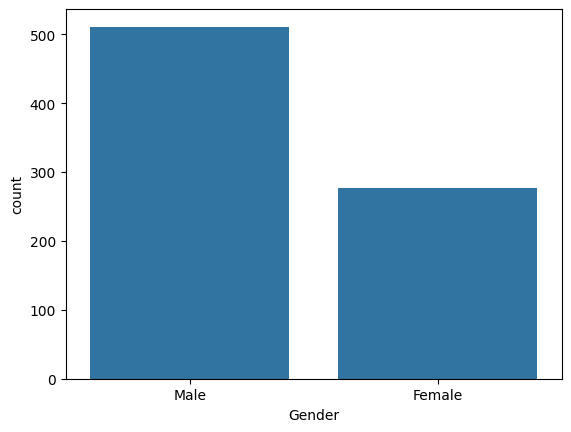

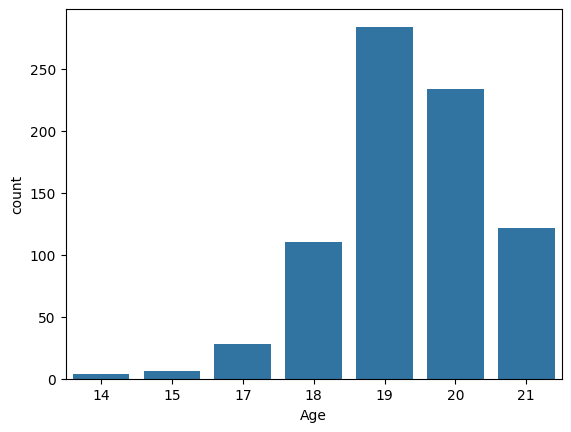

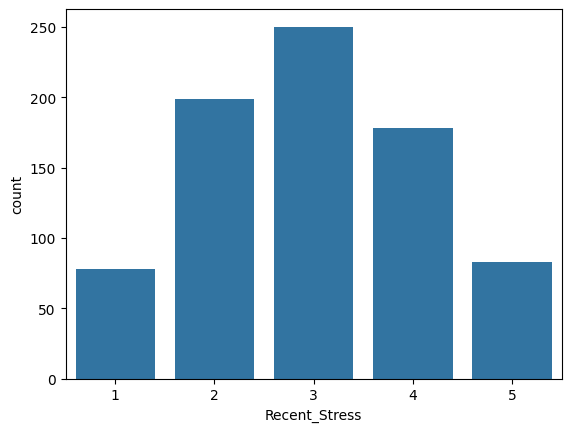

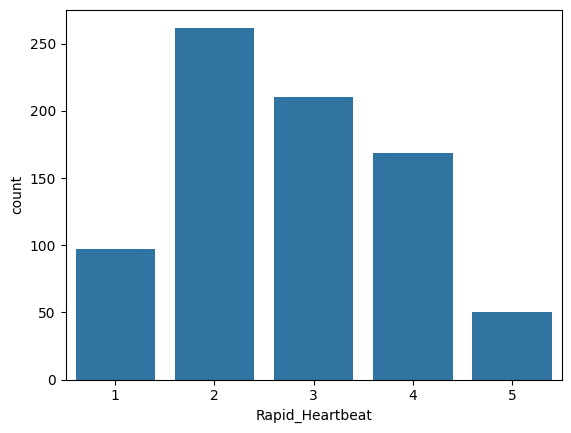

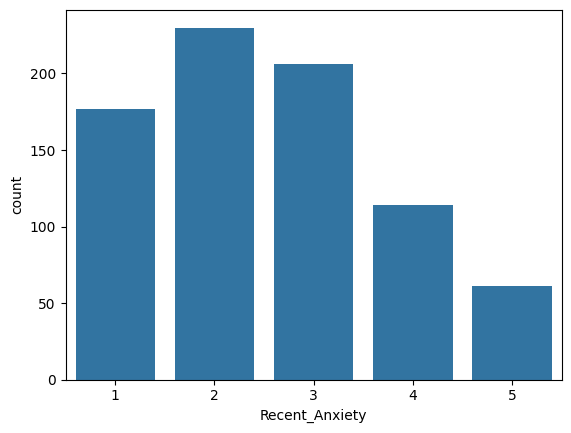

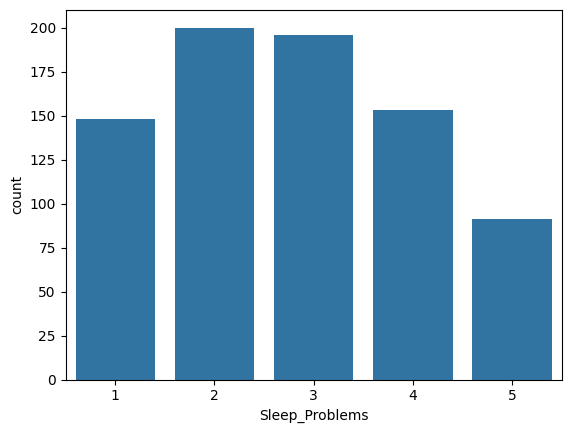

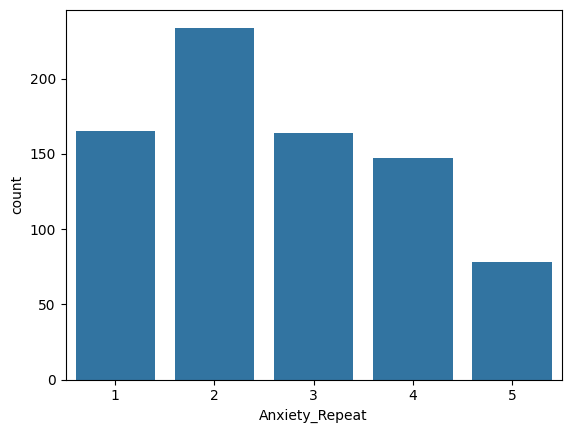

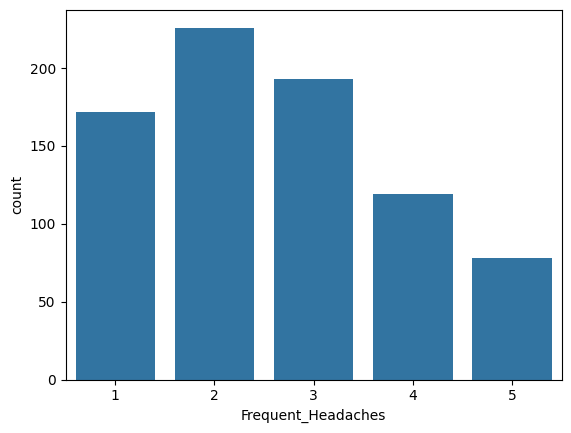

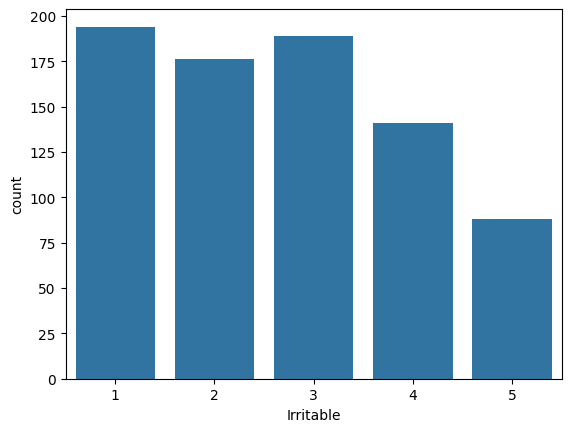

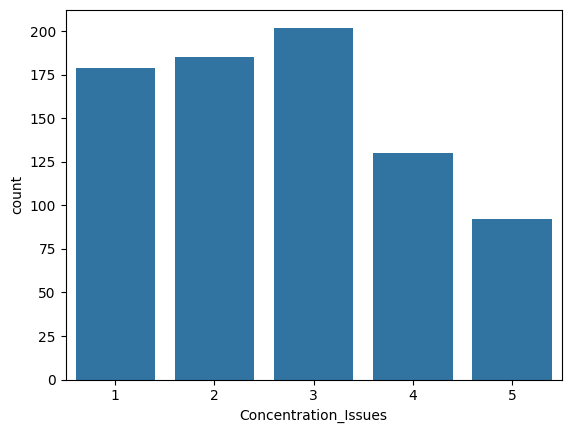

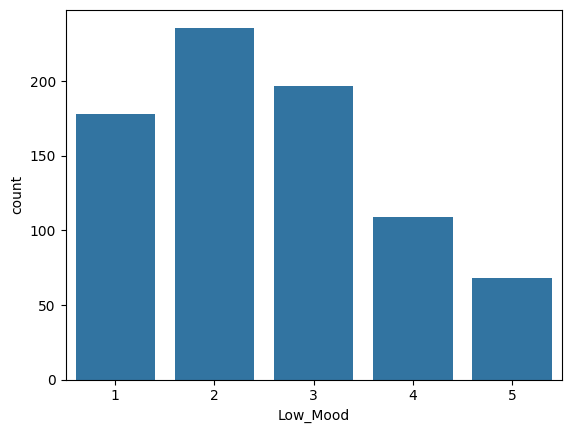

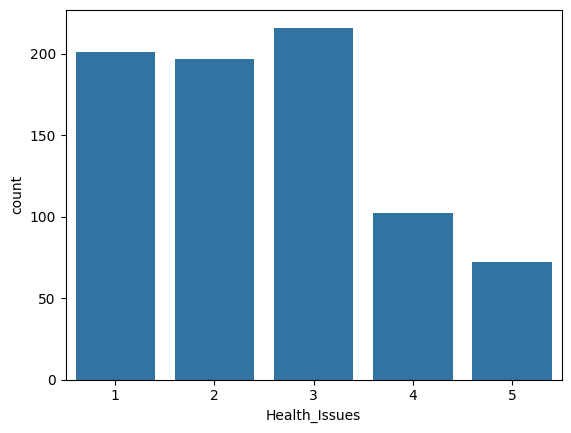

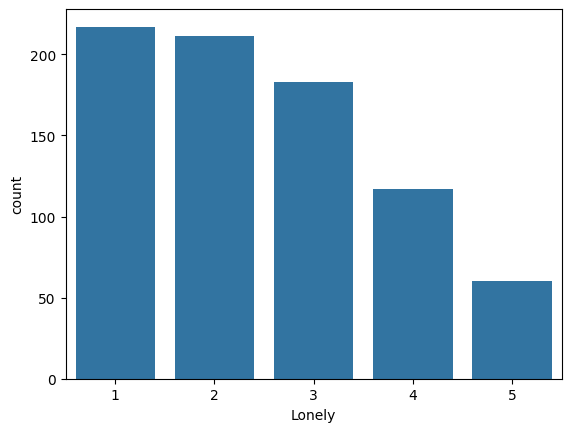

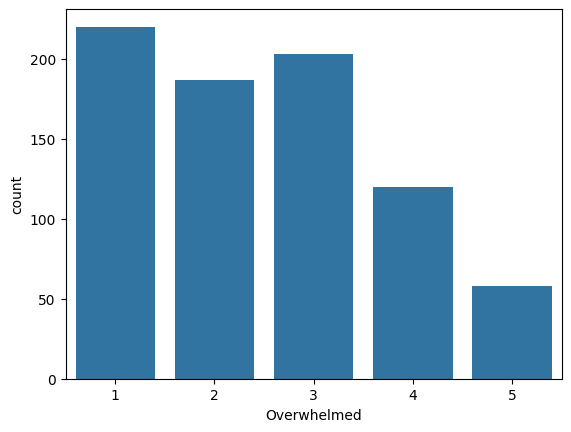

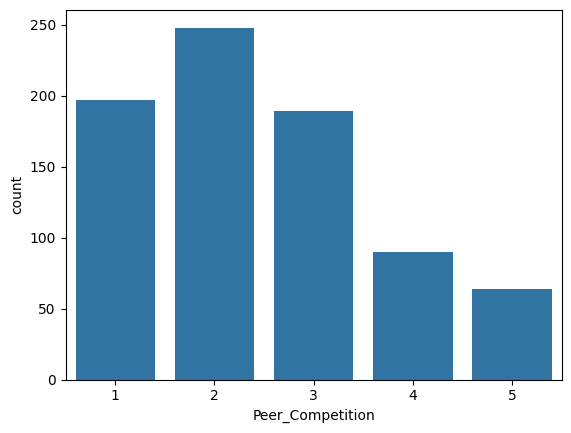

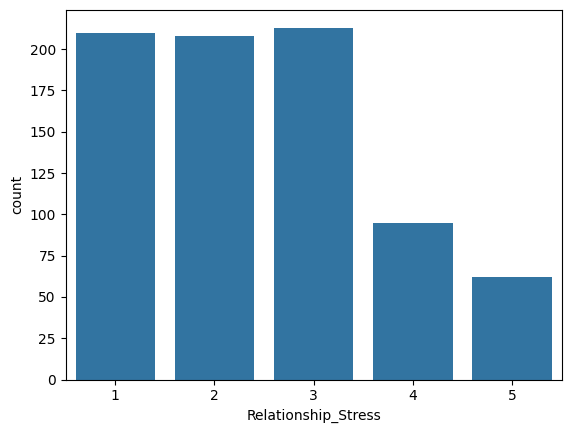

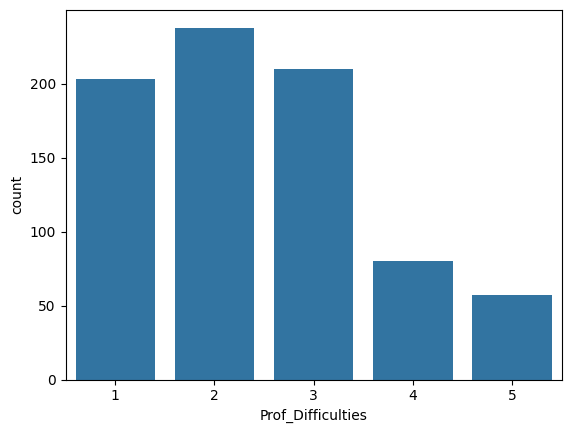

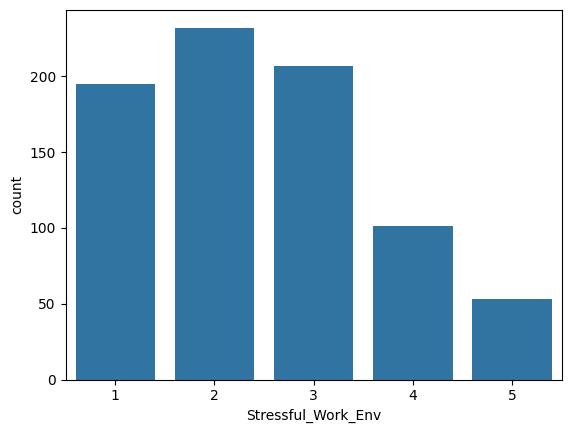

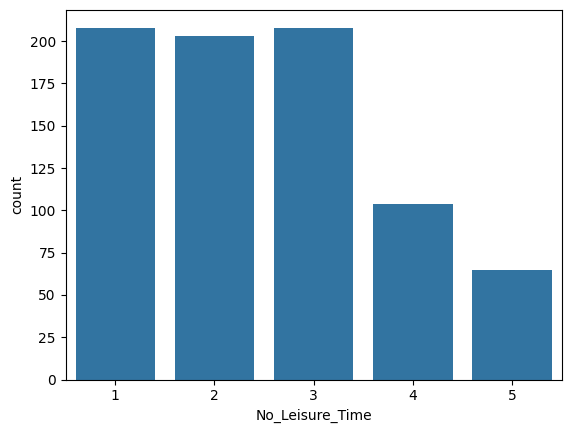

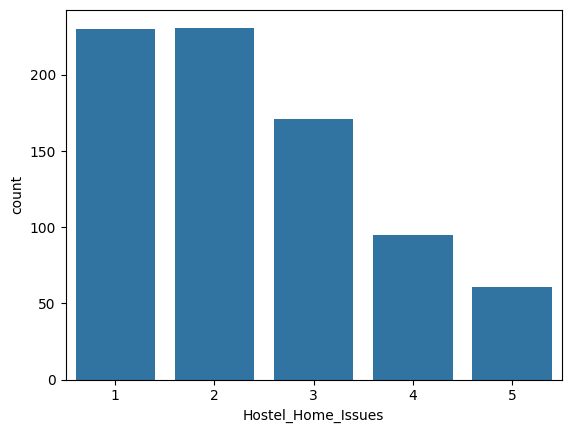

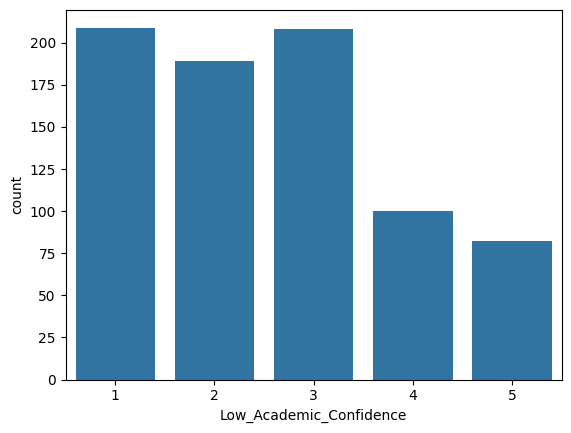

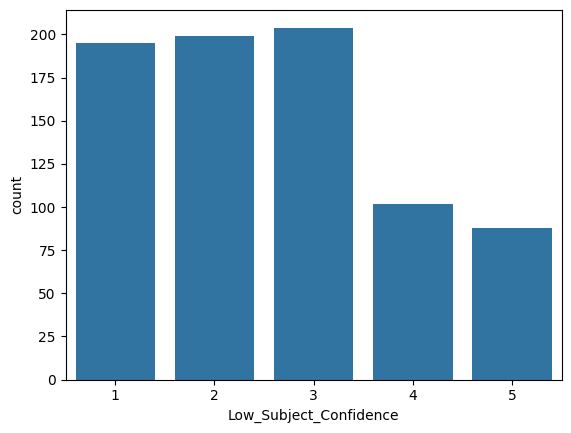

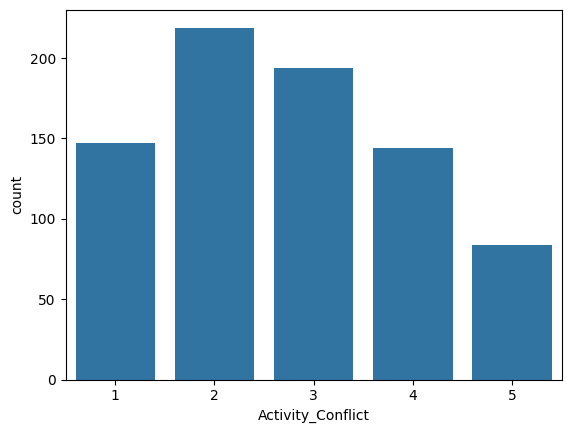

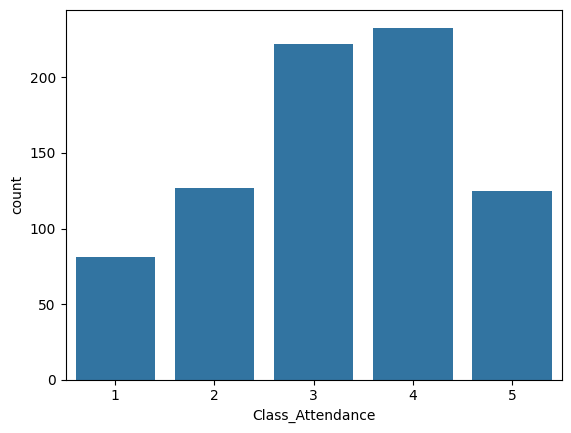

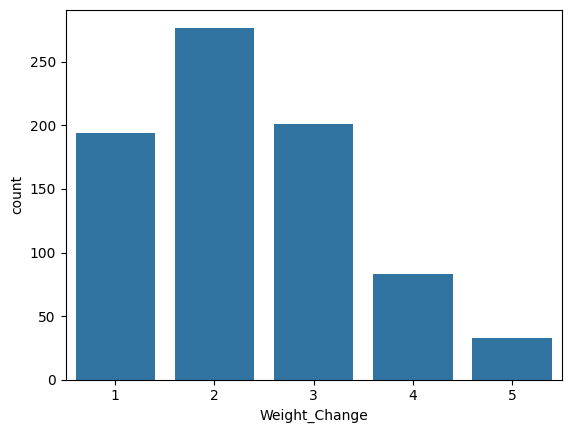

In [17]:
for col in input_cols:
  sns.countplot(df, x=col, fill=True)
  plt.show()

Looking at the data distributions and densities, **males** are by far the most numerous respondents. As for the other columns instead, we can recognise a lot of **bell** and **skewed** curves, suggesting a fair and honest public.

On some features though, especially the ones regarding external factors, it's frequent to see a big drops for high values, probably because of something known as a **normalcy bias**, where people tend to underestimate their situation and choose to vote lower than what's right

Next, we'll see how every of these features **relates** to the target, by graphing barplots indicating the **mean value** of the feature for every **class**

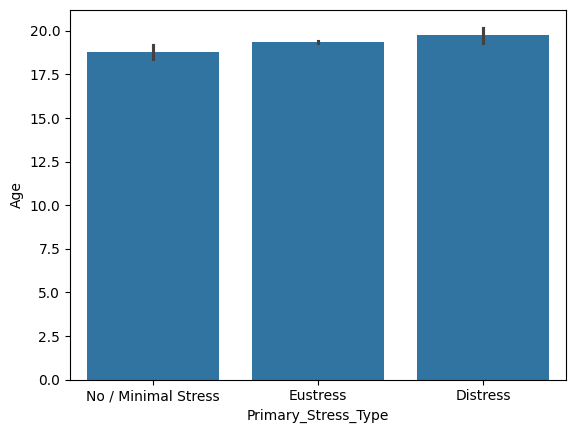

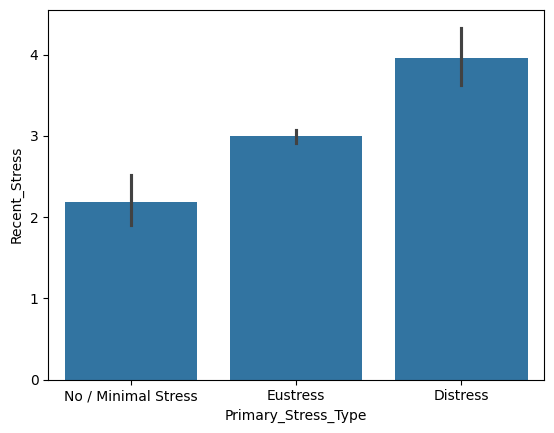

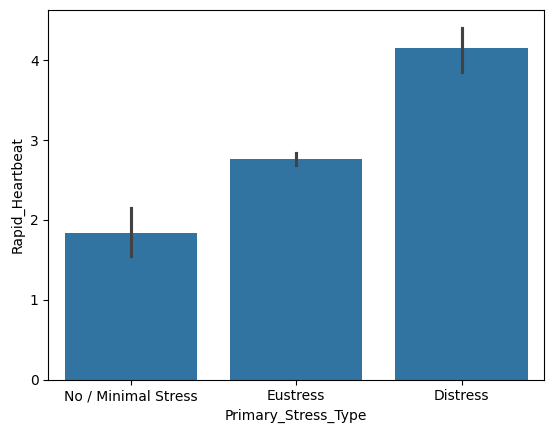

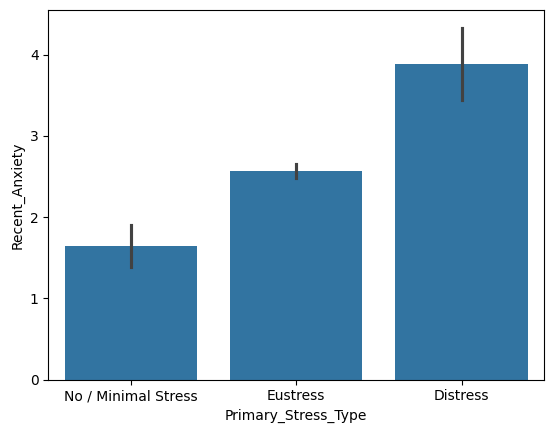

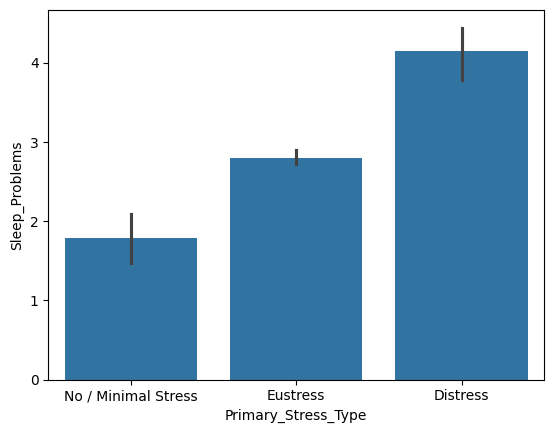

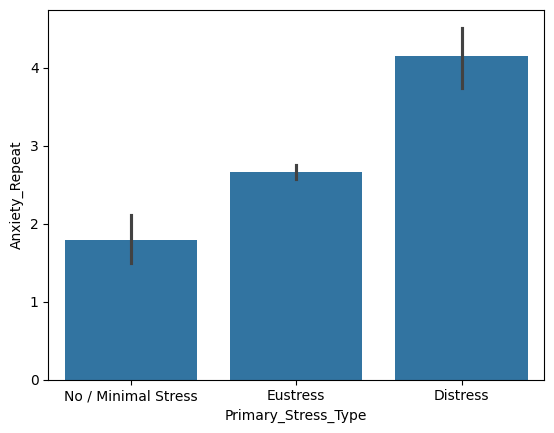

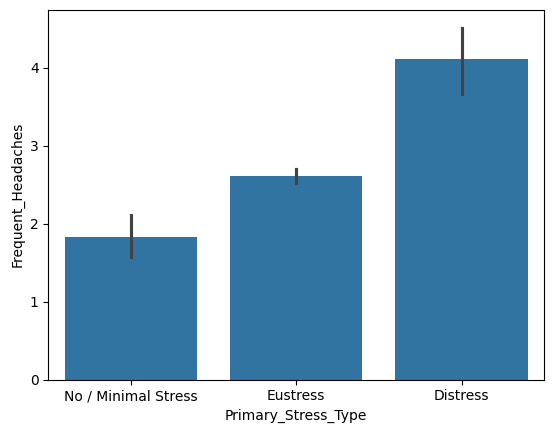

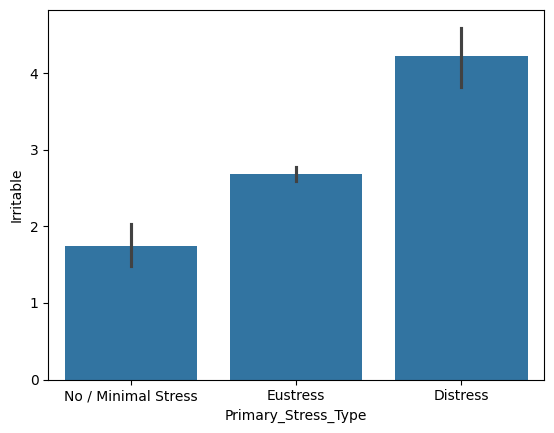

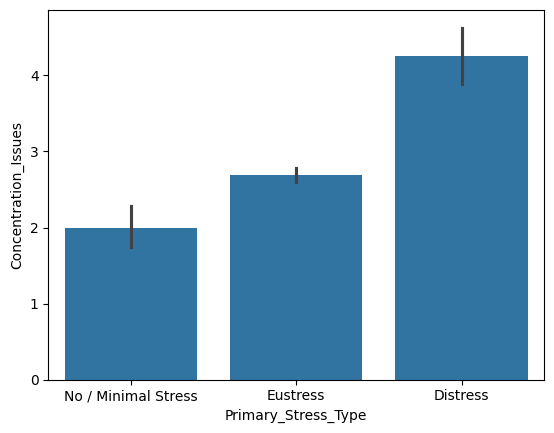

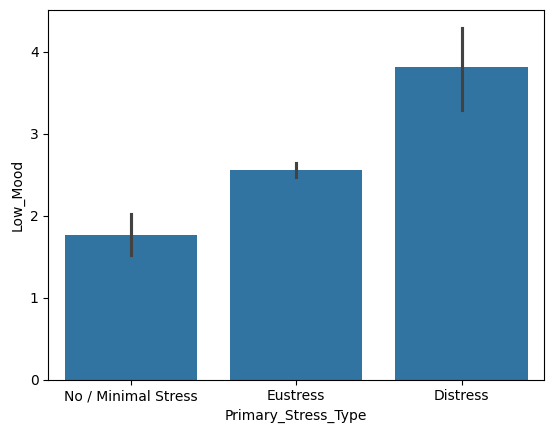

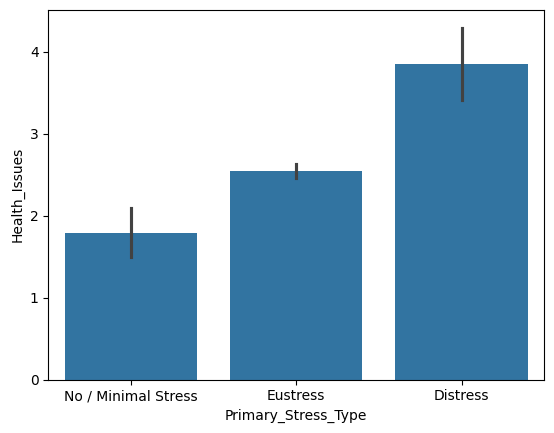

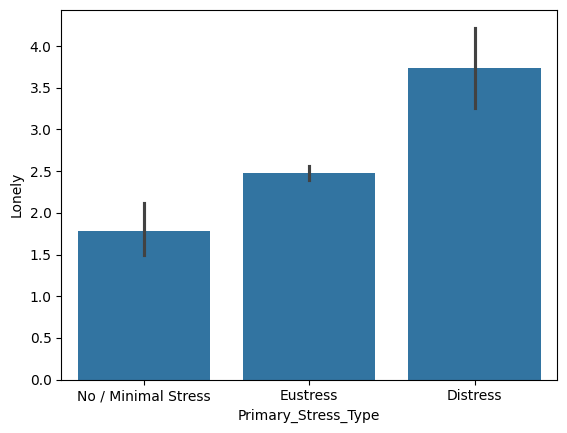

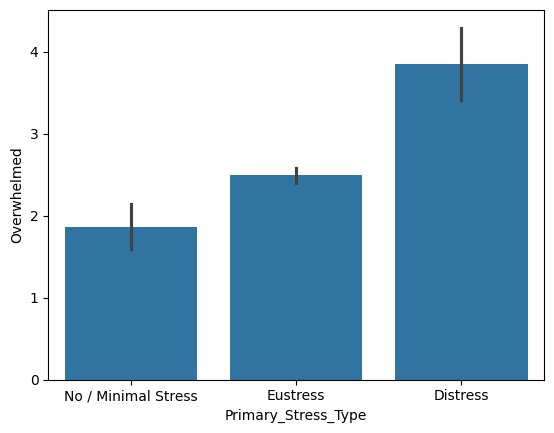

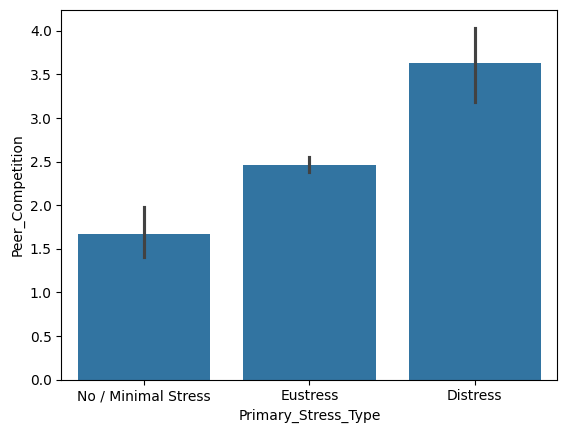

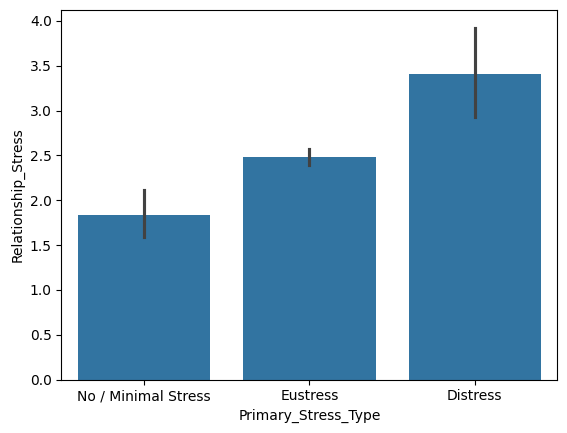

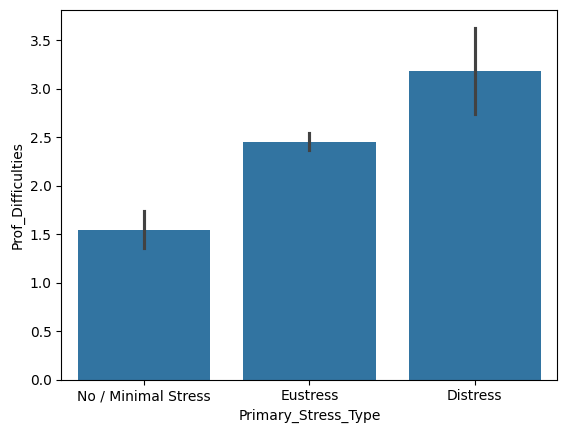

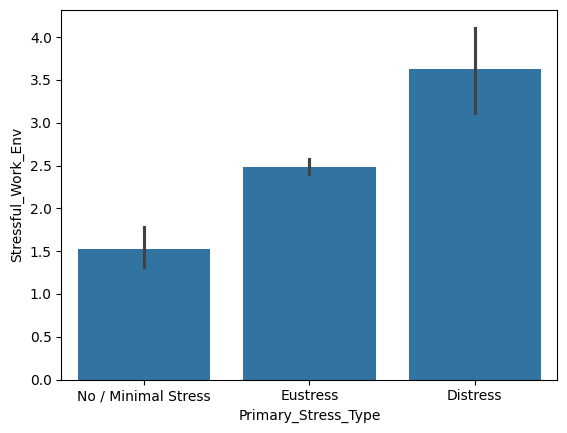

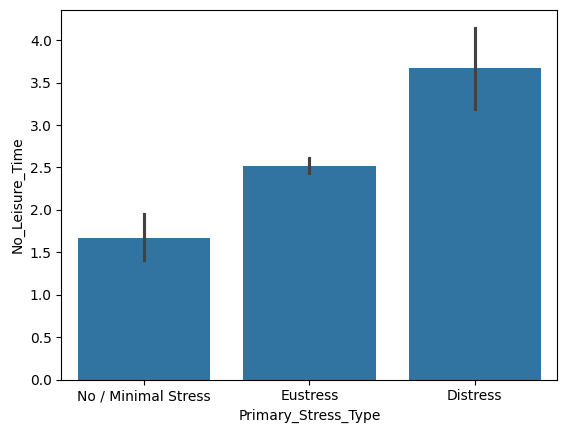

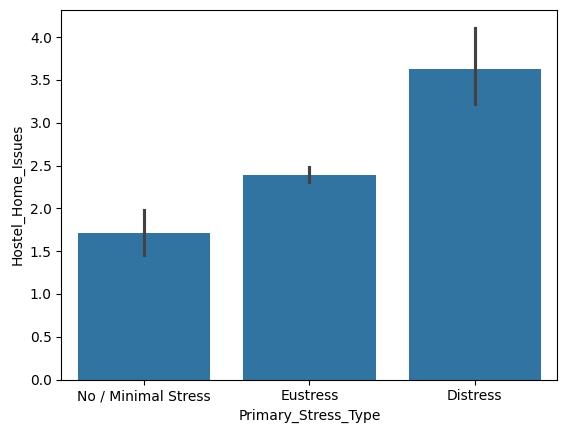

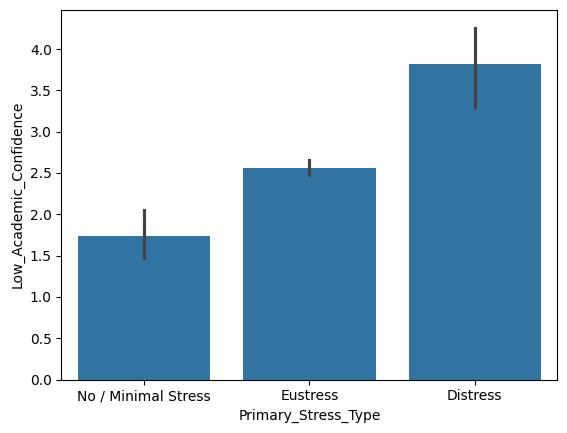

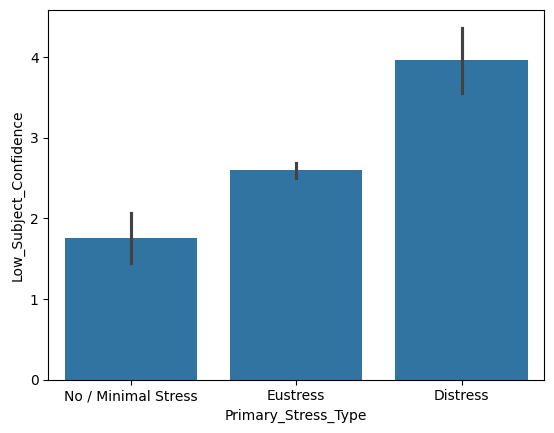

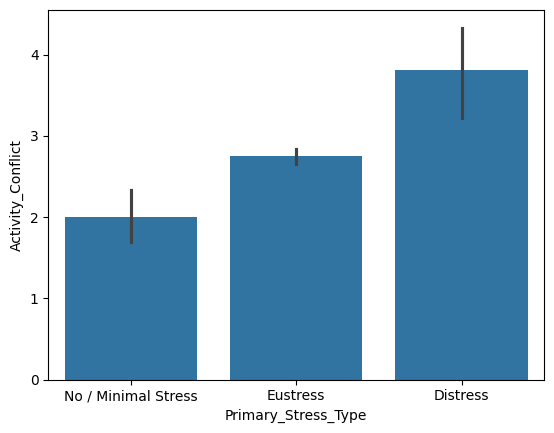

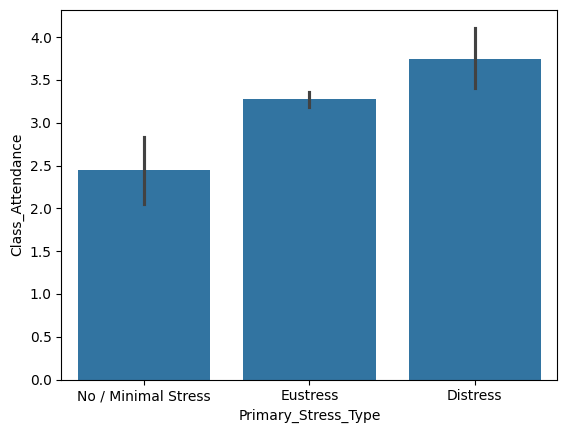

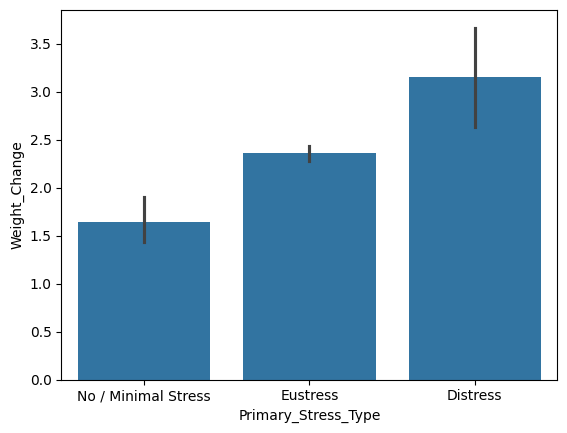

In [18]:
for col in numerical_cols:
  sns.barplot(df, x="Primary_Stress_Type", y=col, order=["No / Minimal Stress", "Eustress", "Distress"])
  plt.show()

Again, apart from age which seems to have little to no correlation with stress type, the remaining columns all follow a **linear-like trend**, **increasing** in values as **stress intensity** increases

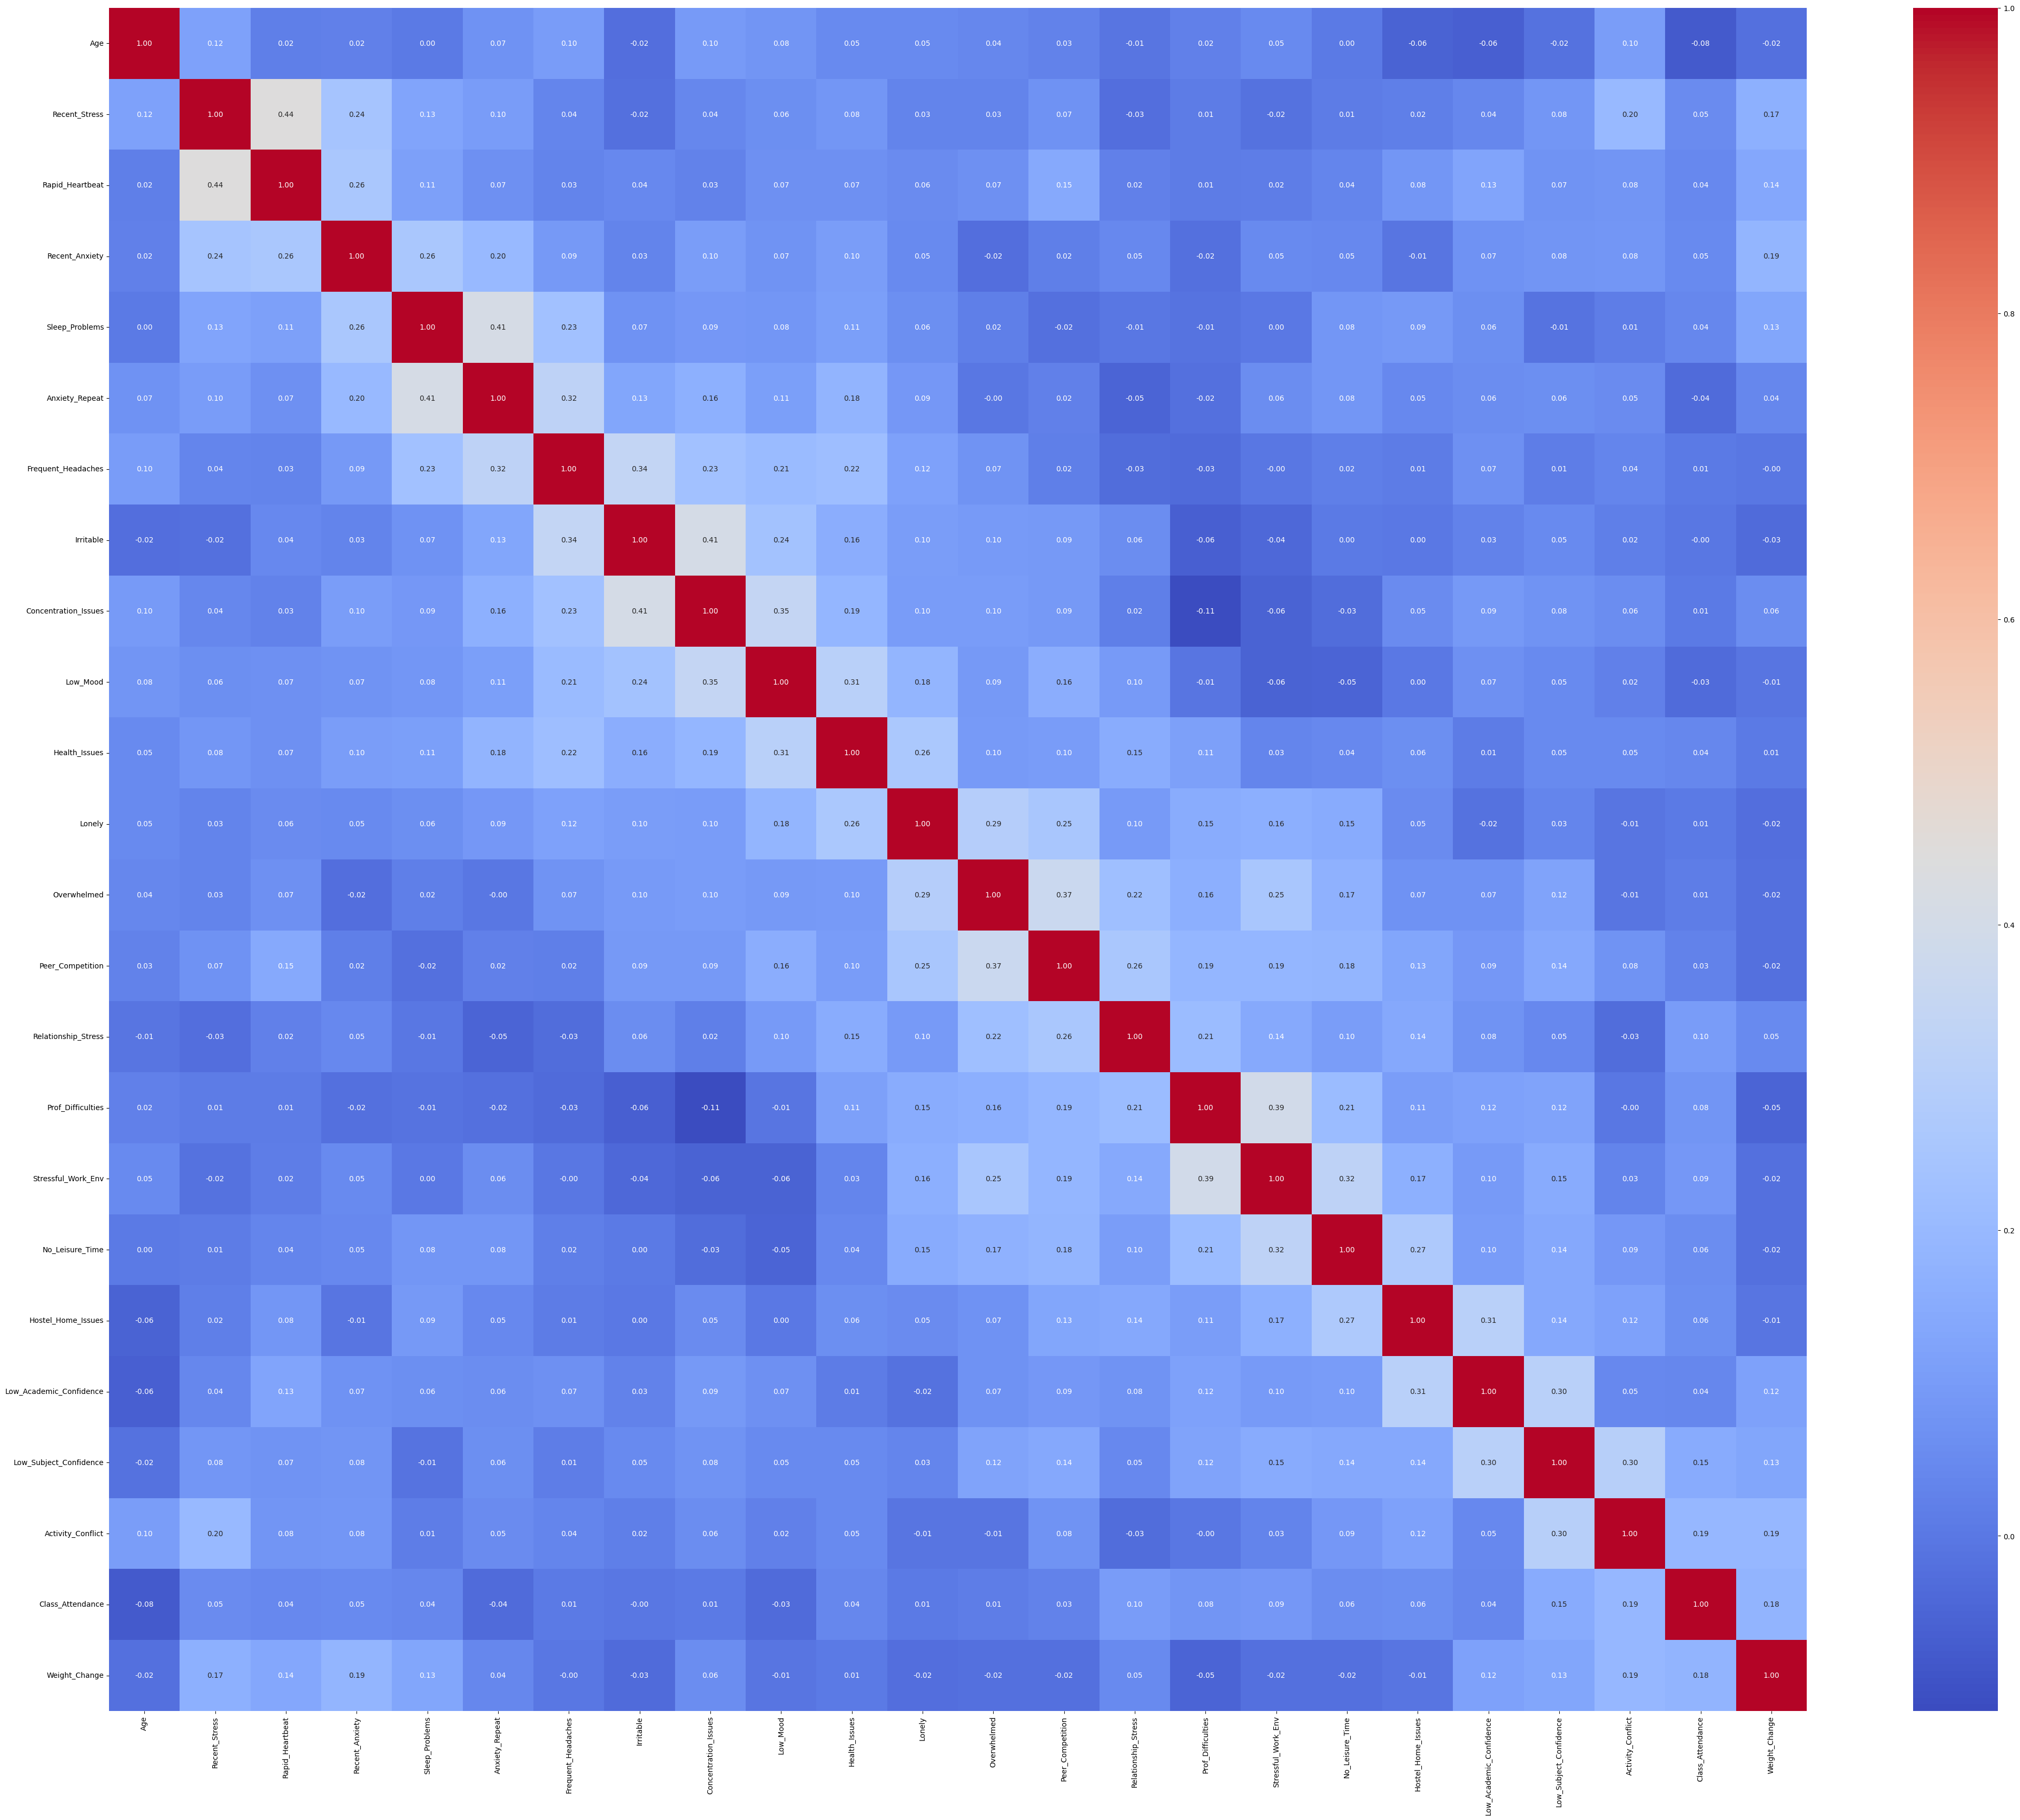

In [23]:
plt.figure(figsize=[52,42])
sns.heatmap(df[numerical_cols].corr(), cmap = "coolwarm", fmt = ".2f", annot = True)
plt.show()

As visible, **no signs** of strong **multicollinearity** are visible, so we can start creating our **predictive model**


*   As categorical columns are, even though in a large minority, still present, we'll need to first **Encode** these to make them usable for our models
* Next, we'll **split** our dataset into two different parts: one will be used for **training**, while the other one will be used to **validate** the model
* Finally, it's time to create the **predictive model**, train it, and test it returning its **score** (which as mentioned, will be a Macro F1-Score on all classes)

---

Several models were tested with different hyperparameter combinations, but ultimately Logistic Regression performed best for this task, so we will proceed with training only this model.

For a complete overview of all the models tested, please refer to the *models_tested.xlsx* file for a detailed breakdown

In [20]:
encoder = OneHotEncoder()
encoder.fit(df[categorical_cols])
encoded_cols = encoder.transform( df[categorical_cols] ).toarray()
encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_cols), index=df.index)
df = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)


df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 42)
train_input = df_train.drop(columns=target_col)
train_output = df_train[target_col]
test_input = df_test.drop(columns=target_col)
test_output = df_test[target_col]

model = LogisticRegression(random_state=42, max_iter=1000, penalty="l2")

model.fit(train_input, train_output)
pred_output = model.predict(test_input)
score = f1_score(test_output, pred_output, average="macro")

print(f"Macro F1-Score: {round(score*100, 2)}%")

Macro F1-Score: 85.38%


The model achieved a Macro F1-score of about 0.8538 (85.38%), indicating balanced predictive performance across all classes.
This suggests that the model effectively captures patterns in both frequent and less frequent categories, balancing precision and recall of all of these classes

For anyone interested in experimenting with this **model**, the complete pipeline will be made available for **download** as *model.pkl*

In [22]:
full_model = {"Encoder": encoder, "Model": model}

joblib.dump(full_model, "model.pkl")

['model.pkl']

## Conclusion

In this project, we analyzed a stress dataset to develop a predictive model capable of reliably identifying the stress type experienced by individuals.

This project showcases an end-to-end Data Science workflow, from data cleaning and exploration to model training and evaluation, providing actionable insights and a reusable predictive pipeline.

The model can be tested directly on my Hugging Face profile without any downloads, available at this [link](https://huggingface.co/spaces/freyflyy/youth-stress-predictor)

> Please note that this is a probabilistic model intended for educational purposes only, and the information it provides has **no legal, medical, or professional value**.

From **raw numbers** to **actionable insights**, this project demonstrates how structured thinking and data-driven approaches can turn **simple data** into **meaningful outcomes**, without requiring large investments.

I hope this work inspires others to harness the power of data to create impactful solutions, that are yet to be discovered

---

*Scolz F.*